In [1]:
from collections import Counter



import plotly.express as px

import plotly.graph_objs as go

from plotly.subplots import make_subplots

import matplotlib.pyplot as plt


import numpy as np

import tensorflow as tf

from tensorflow import keras

import pandas as pd
import sklearn

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [2]:
preprocessed_path = "../data/preprocessed/"

train_df = pd.read_csv(preprocessed_path + "train.csv")
test_df = pd.read_csv(preprocessed_path + "test.csv")
val_df = pd.read_csv(preprocessed_path + "validate.csv")

In [3]:
preprocessed_path = "../data/preprocessed/"

train_df = pd.read_csv(preprocessed_path + "train.csv")
test_df = pd.read_csv(preprocessed_path + "test.csv")
val_df = pd.read_csv(preprocessed_path + "validate.csv")


target = ["TX_FRAUD"]

y_train = train_df[target].values
y_val = val_df[target].values
y_test = test_df[target].values

X_train = train_df.drop(target, axis=1).values
X_val = val_df.drop(target, axis=1).values
X_test = test_df.drop(target, axis=1).values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)
print("Test labels shape:", y_test.shape)

print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)
print("Test features shape:", X_test.shape)

Training labels shape: (67240, 1)
Validation labels shape: (58264, 1)
Test labels shape: (50321, 1)
Training features shape: (67240, 16)
Validation features shape: (58264, 16)
Test features shape: (50321, 16)


In [5]:
not_fraud_count, fraud_count = Counter(y_train.ravel()).values()
total_count = not_fraud_count + fraud_count

weight_for_not_fraud = (1.0 / not_fraud_count) * total_count / 2.0


weight_for_fraud = (1.0 / fraud_count) * total_count / 2.0



class_weight = {0: weight_for_not_fraud, 1: weight_for_fraud}

class_weight

{0: 0.5044866600642237, 1: 56.220735785953174}

In [6]:
# bias fix to speed up training
# see https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias
output_bias = tf.keras.initializers.Constant(np.log([fraud_count / not_fraud_count]))

model = keras.Sequential(
    [
        keras.layers.Dense(500, activation="relu", input_shape=(X_train.shape[-1],)),
        keras.layers.Dense(500, activation="relu", input_shape=(X_train.shape[-1],)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc"),
        keras.metrics.AUC(name="prc", curve="PR"),
    ],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               8500      
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 501       
                                                                 
Total params: 259,501
Trainable params: 259,501
Non-trainable params: 0
_________________________________________________________________


In [7]:
BATCH_SIZE = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_prc", verbose=1, patience=10, mode="max", restore_best_weights=True
)

training_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=40,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    class_weight=class_weight,
)

Epoch 1/40
1051/1051 [==============================] - 5s 4ms/step - loss: 0.4568 - precision: 0.0742 - recall: 0.7358 - auc: 0.8634 - prc: 0.4406 - val_loss: 0.1724 - val_precision: 0.2037 - val_recall: 0.6831 - val_auc: 0.8527 - val_prc: 0.5659
Epoch 2/40
1051/1051 [==============================] - 5s 4ms/step - loss: 0.3579 - precision: 0.0926 - recall: 0.7826 - auc: 0.8977 - prc: 0.5381 - val_loss: 0.0952 - val_precision: 0.3291 - val_recall: 0.6805 - val_auc: 0.8557 - val_prc: 0.6026
Epoch 3/40
1051/1051 [==============================] - 4s 4ms/step - loss: 0.3467 - precision: 0.0979 - recall: 0.7910 - auc: 0.9045 - prc: 0.5312 - val_loss: 0.3721 - val_precision: 0.0400 - val_recall: 0.7558 - val_auc: 0.8545 - val_prc: 0.4415
Epoch 4/40
1051/1051 [==============================] - 6s 6ms/step - loss: 0.3422 - precision: 0.1066 - recall: 0.7960 - auc: 0.9045 - prc: 0.5224 - val_loss: 0.3052 - val_precision: 0.0514 - val_recall: 0.7403 - val_auc: 0.8490 - val_prc: 0.5411
Epoch 5/

In [8]:
res = []

metrics_to_plot = [
    ("loss", "Loss"),
    ("precision", "Precision"),
    ("recall", "Recall"),
    ("auc", "Area under ROC curve"),
    ("prc", "Area under PR curve"),
]
fig = make_subplots(rows=len(metrics_to_plot), cols=1)

for metric, name in metrics_to_plot:
    fig = go.Figure(
        data=[
            go.Scatter(
                x=training_history.epoch,
                y=training_history.history[metric],
                mode="lines",
                name="Training",
            ),
            go.Scatter(
                x=training_history.epoch,
                y=training_history.history["val_" + metric],
                mode="lines",
                line={"dash": "dash"},
                name="Validation",
            ),
        ]
    )
    fig.update_yaxes(title=name)
    fig.update_xaxes(title="Epoch")

    if (metric, name) == metrics_to_plot[0]:
        fig.update_layout(
            height=250, title="Training history", margin={"b": 0, "t": 50}
        )
    else:
        fig.update_layout(height=200, margin={"b": 0, "t": 0})
    fig.show()

In [9]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

predictions_df = pd.DataFrame(
    {"Prediction": train_predictions.ravel(), "Label": y_train.ravel()}
)
predictions_df = pd.concat(
    [
        predictions_df[predictions_df["Label"] == 0].sample(5000, random_state=0),
        predictions_df[predictions_df["Label"] == 1].sample(500, random_state=0),
    ]
)
fig = px.histogram(
    predictions_df,
    x="Prediction",
    title="Prediction values",
    color="Label",
    marginal="box",
    labels={"0": "Legitimate", "1": "Fraudulent"},
)
fig.update_traces(opacity=0.75)
fig.update_layout(barmode="overlay")
fig.show()

787/787 [==============================] - 1s 1ms/step


In [10]:
def make_roc_df(name, predictions, labels):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    return pd.DataFrame({"fp": fp * 100, "tp": tp * 100, "Dataset": name})


roc_df = pd.concat(
    [
        make_roc_df("Training", train_predictions, y_train),
        make_roc_df("Test", test_predictions, y_test),
    ]
)

fig = px.line(
    roc_df,
    title="ROC Curve",
    x="fp",
    y="tp",
    color="Dataset",
    labels={"fp": "False Positives (%)", "tp": "True Positives (%)"},
)
fig.update_yaxes(range=[60, 100])
fig.update_traces(line={"dash": "dash"}, selector={"name": "test"})
fig.show()

In [11]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [12]:
print(classification_report(y_test, [1 if x > 0.5 else 0 for x in test_predictions]))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     50014
           1       0.30      0.68      0.42       307

    accuracy                           0.99     50321
   macro avg       0.65      0.84      0.71     50321
weighted avg       0.99      0.99      0.99     50321



Text(0, 0.5, '')

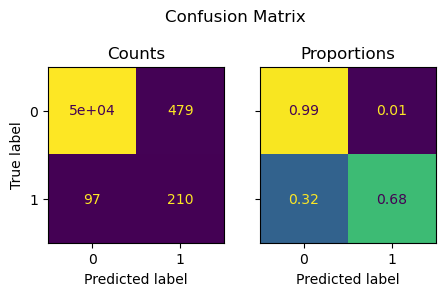

In [15]:
y_test = y_test
y_pred = [1 if x > 0.5 else 0 for x in test_predictions]

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], colorbar=False)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize="true",
    values_format=".2f",
    ax=ax[1],
    im_kw={"vmin": 0, "vmax": 1},
    colorbar=False,
)
fig.suptitle("Confusion Matrix")
ax[0].set_title("Counts")
ax[1].set_title("Proportions")
ax[1].set_ylabel(None)